# Практическое задание №1

## Прогнозирование продаж сети магазинов Эквадора с помощью эконометрических моделей

**Выполнили:** Кирякин Максим, Куренкова Дарья, Коваль Наталья

**Источник данные:** https://www.kaggle.com/c/store-sales-time-series-forecasting/data

### Постановка задачи

Требуется предсказать с помощью эконометрической модели число продаж в сети магазинов Эквадора, на основе данных о продаже за год.


### Подготовка среды

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm

from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor

from hyperopt.fmin import fmin
from hyperopt.pyll import scope
from hyperopt import hp, tpe, Trials, STATUS_OK

from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

import pickle
from Utils.graphs import *

graphsDir = "./Plots"
UseBackUpData = False

### Загрузка и обработка данных

**train.csv**

Обучающие данные, состоящие из временных рядов -- признаков: `store_nbr`, `family` и `onpromotion`, а также целевых продаж.

Описание значений переменных:
- `store_nbr` идентифицирует магазин, в котором продаются товары.  
- `family` определяет тип продаваемого продукта.  
- `sales` указывает общую сумму продаж для определенной группы товаров в конкретном магазине на заданную дату. Возможны дробные значения, так как товары могут продаваться в дробных единицах (например, 1,5 кг сыра вместо 1 пакета чипсов).  
- `onpromotion` указывает общее количество товаров в группе продуктов, которые были на акции в магазине на заданную дату.

**stores.csv**

Метаданные магазинов, включая город, штат, тип и кластер.  
Кластер — это группа схожих магазинов.

**oil.csv**

Ежедневные цены на нефть. Включает значения как в период обучения, так и в период тестирования. (Эквадор — страна, зависимая от нефти, и ее экономическое состояние сильно подвержено колебаниям цен на нефть.)


In [2]:
labels = {
    "store_nbr":    "id магазина",
    "sales":        "Число продаж",
    "onpromotion":  "Число акций",
    "dcoilwtico":   "Цена топлива",
    "transactions": "Число транзакций",
    "city":         "Страна",
    "cluster":      "Группа"
}

In [3]:
data = [
    "holidays_events.csv",
    "oil.csv",
    "stores.csv",
    "train.csv",
    "transactions.csv"
]

leftDate, rightDate = '2016-01-01', '2017-01-01'
dataframes = {}

for file in data:
    name = file.split(".")[0]
    dataframes[name] = pd.read_csv("Data/" + file)

dataframes["trainTotal"] = (
    dataframes["train"]
    .merge(dataframes["holidays_events"].drop_duplicates("date"), on="date", how="left")
    .merge(dataframes["oil"].drop_duplicates("date"), on="date", how="left")
    .merge(dataframes["transactions"], on=["date", "store_nbr"], how="left")
    .merge(dataframes["stores"].drop_duplicates("store_nbr"), on="store_nbr", how="left")
    .rename(columns = {'type_x' : "holiday_type", "type_y" : "store_type"})
)
assert dataframes["trainTotal"].shape[0] == dataframes["train"].shape[0]

In [4]:
timeBasedFeatures = ["dayofweek", "quarter", "month", "year",
                     "dayofyear", "day", "week", "lag1", "lag2", "lag3"]

dataframes["trainTotal"] = (
    dataframes["trainTotal"]
    .assign(date=pd.to_datetime(dataframes["trainTotal"]["date"], format='%Y-%m-%d'))
    .assign(dayofweek=lambda df: df['date'].dt.dayofweek)
    .assign(quarter=lambda df: df['date'].dt.quarter)
    .assign(month=lambda df: df['date'].dt.month)
    .assign(year=lambda df: df['date'].dt.year)
    .assign(dayofyear=lambda df: df['date'].dt.dayofyear)
    .assign(day=lambda df: df['date'].dt.day)
    .assign(week=lambda df: df['date'].dt.isocalendar().week)
)

dataframes["trainTotal"] = (
    dataframes["trainTotal"]
    .astype({"week": np.int32, "day": np.int32, "dayofyear": np.int32, "year": np.int32,
             "month": np.int32, "quarter": np.int32, "dayofweek": np.int32})
)

In [5]:
dataframes["trainTotal"] = dataframes["trainTotal"].set_index("date")

target_map = dataframes["trainTotal"]["sales"].to_dict()
dataframes["trainTotal"] = (
    dataframes["trainTotal"]
    .assign(lag1 = (dataframes["trainTotal"].index - pd.Timedelta("364 days")).map(target_map))
    .assign(lag2 = (dataframes["trainTotal"].index - pd.Timedelta("728 days")).map(target_map))
    .assign(lag3 = (dataframes["trainTotal"].index - pd.Timedelta("1092 days")).map(target_map))
)
dataframes["trainTotal"] = (
    dataframes["trainTotal"]
    .fillna({"lag1": dataframes["trainTotal"]["lag1"].mean()})
    .fillna({"lag2": dataframes["trainTotal"]["lag2"].mean()})
    .fillna({"lag3": dataframes["trainTotal"]["lag3"].mean()})
)

dataframes["trainTotal"] = dataframes["trainTotal"].reset_index()

In [6]:
dataframes["trainTotal"].head(5)

,date,id,store_nbr,family,sales,onpromotion,holiday_type,locale,locale_name,description,...,dayofweek,quarter,month,year,dayofyear,day,week,lag1,lag2,lag3
0,2013-01-01,0,1,AUTOMOTIVE,0.0,0,Holiday,National,Ecuador,Primer dia del ano,...,1,1,1,2013,1,1,1,16.82389,16.216993,16.272834
1,2013-01-01,1,1,BABY CARE,0.0,0,Holiday,National,Ecuador,Primer dia del ano,...,1,1,1,2013,1,1,1,16.82389,16.216993,16.272834
2,2013-01-01,2,1,BEAUTY,0.0,0,Holiday,National,Ecuador,Primer dia del ano,...,1,1,1,2013,1,1,1,16.82389,16.216993,16.272834
3,2013-01-01,3,1,BEVERAGES,0.0,0,Holiday,National,Ecuador,Primer dia del ano,...,1,1,1,2013,1,1,1,16.82389,16.216993,16.272834
4,2013-01-01,4,1,BOOKS,0.0,0,Holiday,National,Ecuador,Primer dia del ano,...,1,1,1,2013,1,1,1,16.82389,16.216993,16.272834


In [7]:
specification = {}
specification.update({"columns" : dataframes["trainTotal"].columns})
with open("Spec/specification.pkl", "wb") as f:
    pickle.dump(specification, f)

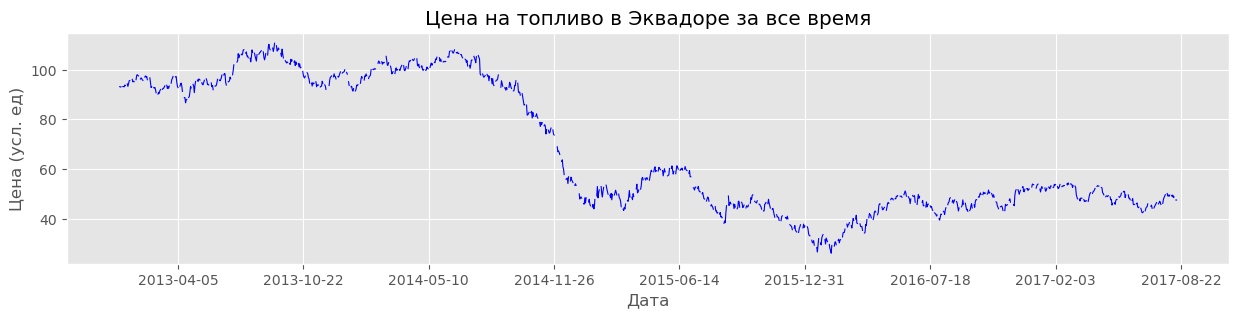

In [8]:
data = (
    dataframes["trainTotal"][["date", "dcoilwtico"]]
    .set_index("date")
    .rename(columns={"dcoilwtico": "Цена на топливо"})
    .reset_index()
)

plotTimeSeries(data=data, X="date", y="Цена на топливо", xlabel="Дата", color="blue",
               title="Цена на топливо в Эквадоре за все время", ylabel="Цена (усл. ед)",
               linewidth=0.8, savePath=f"{graphsDir}/OilPrice.png");

In [9]:
dataframes["trainTotal"] = (
    dataframes["trainTotal"]
    .assign(dcoilwtico=dataframes["trainTotal"]['dcoilwtico'].interpolate(method='polynomial', order=2))
    .assign(transactions=dataframes["trainTotal"]['transactions'].fillna(dataframes["trainTotal"]['transactions'].mean()))
)

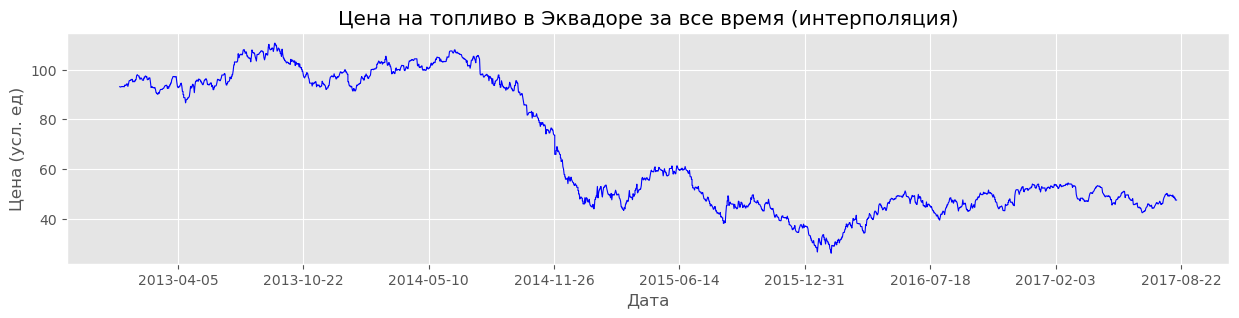

In [10]:
data = (
    dataframes["trainTotal"][["date", "dcoilwtico"]]
    .set_index("date")
    .rename(columns={"dcoilwtico": "Цена на топливо"})
    .reset_index()
)

plotTimeSeries(data=data, X="date", y="Цена на топливо", xlabel="Дата", color="blue",
               title="Цена на топливо в Эквадоре за все время (интерполяция)", ylabel="Цена (усл. ед)",
               linewidth=0.8, savePath=f"{graphsDir}/OilPriceEnterpolated.png");

In [11]:
dataframes["trainTotal"] = dataframes["trainTotal"].query("(date >= @leftDate) & (date < @rightDate)")

In [12]:
size = dataframes["trainTotal"].shape[0]
(
    pd.DataFrame(dataframes["trainTotal"].isna().sum()).reset_index().rename(columns={"index":"column", 0: "missing"})
    .eval("share=missing/@size")
    .query("missing > 0")
)

,column,missing,share
6,holiday_type,518562,0.79726
7,locale,518562,0.79726
8,locale_name,518562,0.79726
9,description,518562,0.79726
10,transferred,518562,0.79726


In [13]:
dataframes["trainTotal"] = (
    dataframes["trainTotal"]
    .drop(columns=["holiday_type", "locale", "locale_name", "description", "transferred"])
)

In [14]:
size = dataframes["trainTotal"].shape[0]
tmp = (
    pd.DataFrame(dataframes["trainTotal"].isna().sum()).reset_index().rename(columns={"index":"column", 0: "missing"})
    .eval("share=missing/@size")
    .query("missing > 0")
)
assert tmp.shape[0] == 0

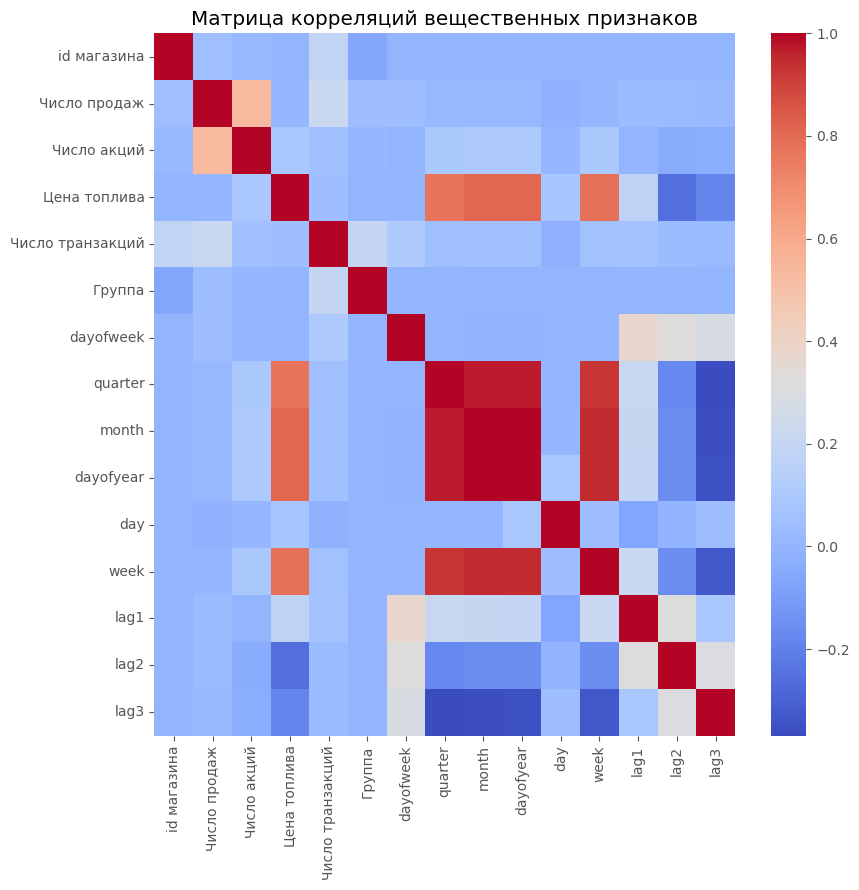

In [15]:
fig, ax = plt.subplots(figsize=(9, 9))
numColsToDrop = list(dataframes["trainTotal"].select_dtypes(exclude=[np.number]).columns) + ["id", "year"]
data = dataframes["trainTotal"].drop(columns=numColsToDrop).rename(columns=labels)

corr = data.corr()

sns.heatmap(corr, cmap="coolwarm", ax = ax)
ax.set_title("Матрица корреляций вещественных признаков")
plt.savefig(f"{graphsDir}/CorrMatrix.png", bbox_inches='tight'),
plt.tight_layout(), plt.show();

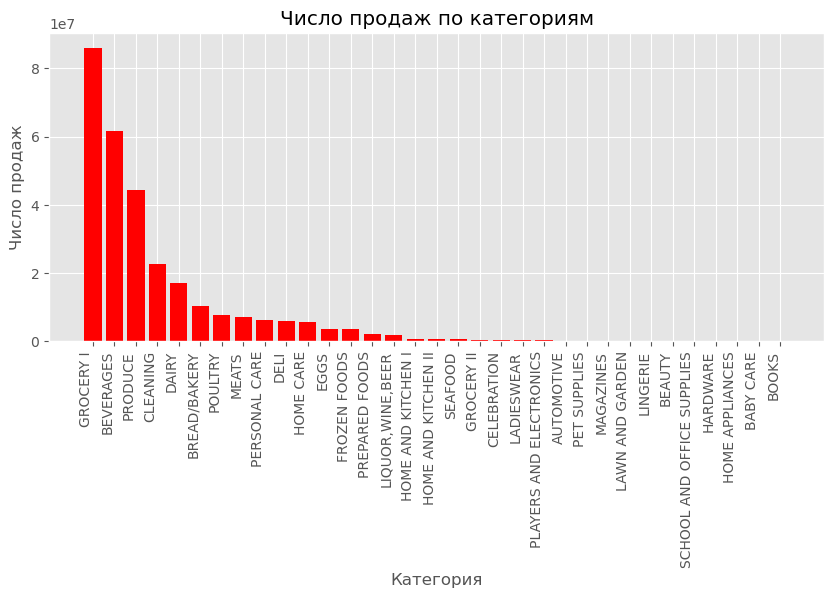

In [16]:
plt.figure(figsize=(10, 4))
data = (
    dataframes["trainTotal"]
    .groupby('family')['sales']
    .sum()
    .reset_index()
    .sort_values(by='sales', ascending=False)
)

plt.bar(data['family'], data['sales'], color='red')

plt.xticks(rotation=90, ha='right')

plt.title('Число продаж по категориям')
plt.xlabel('Категория')
plt.ylabel('Число продаж')
plt.savefig(f"{graphsDir}/CategoriesDistribution.png", bbox_inches='tight');

In [17]:
dataframes["trainTotal"].head(5)

,date,id,store_nbr,family,sales,onpromotion,dcoilwtico,transactions,city,state,...,dayofweek,quarter,month,year,dayofyear,day,week,lag1,lag2,lag3
1945944,2016-01-01,1945944,1,AUTOMOTIVE,0.0,0,37.130000,1694.602158,Quito,Pichincha,...,4,1,1,2016,1,1,53,23.0,8.0,11.0
1945945,2016-01-01,1945945,1,BABY CARE,0.0,0,37.130000,1694.602158,Quito,Pichincha,...,4,1,1,2016,1,1,53,23.0,8.0,11.0
1945946,2016-01-01,1945946,1,BEAUTY,0.0,0,37.130000,1694.602158,Quito,Pichincha,...,4,1,1,2016,1,1,53,23.0,8.0,11.0
1945947,2016-01-01,1945947,1,BEVERAGES,0.0,0,37.130000,1694.602158,Quito,Pichincha,...,4,1,1,2016,1,1,53,23.0,8.0,11.0
1945948,2016-01-01,1945948,1,BOOKS,0.0,0,37.129999,1694.602158,Quito,Pichincha,...,4,1,1,2016,1,1,53,23.0,8.0,11.0


In [18]:
catColumns = ["family","store_nbr", "city", "state", "store_type", "cluster"]

for cat in catColumns:
    label_encoder = LabelEncoder()
    dataframes["trainTotal"][cat] = label_encoder.fit_transform(dataframes["trainTotal"][cat])

In [19]:
dataframes["trainTotal"].head(5)

,date,id,store_nbr,family,sales,onpromotion,dcoilwtico,transactions,city,state,...,dayofweek,quarter,month,year,dayofyear,day,week,lag1,lag2,lag3
1945944,2016-01-01,1945944,0,0,0.0,0,37.130000,1694.602158,18,12,...,4,1,1,2016,1,1,53,23.0,8.0,11.0
1945945,2016-01-01,1945945,0,1,0.0,0,37.130000,1694.602158,18,12,...,4,1,1,2016,1,1,53,23.0,8.0,11.0
1945946,2016-01-01,1945946,0,2,0.0,0,37.130000,1694.602158,18,12,...,4,1,1,2016,1,1,53,23.0,8.0,11.0
1945947,2016-01-01,1945947,0,3,0.0,0,37.130000,1694.602158,18,12,...,4,1,1,2016,1,1,53,23.0,8.0,11.0
1945948,2016-01-01,1945948,0,4,0.0,0,37.129999,1694.602158,18,12,...,4,1,1,2016,1,1,53,23.0,8.0,11.0


In [20]:
mode_function = lambda x: x.mode()[0]
mean_columns  = ["sales", "onpromotion", "dcoilwtico", "transactions"]
mode_columns  = [
    "store_nbr", "family", "city", "state", "store_type", "cluster",
    "lag1", "lag2", "lag3", "dayofweek", "quarter", "month", "year",
    "dayofyear", "day", "week"
]

agg_dict = {i: mode_function for i in mode_columns}
agg_dict.update({i:"mean"  for i in mean_columns})

trainDF = dataframes["trainTotal"].groupby("date").agg(agg_dict).reset_index()
trainDF.head(5)

,date,store_nbr,family,city,state,store_type,cluster,lag1,lag2,lag3,...,quarter,month,year,dayofyear,day,week,sales,onpromotion,dcoilwtico,transactions
0,2016-01-01,0,0,18,12,3,2,23.0,8.000000,11.000,...,1,1,2016,1,1,53,9.221882,0.089226,37.106277,1694.602158
1,2016-01-02,0,0,18,12,3,2,18.0,11.809999,28.361,...,1,1,2016,2,2,53,598.584414,1.028058,36.970000,1854.274794
2,2016-01-03,0,0,18,12,3,2,31.0,35.353000,36.553,...,1,1,2016,3,3,53,688.403883,1.647587,36.833723,1694.602158
3,2016-01-04,0,0,18,12,3,2,16.0,14.000000,18.444,...,1,1,2016,4,4,1,536.451670,0.976992,36.810000,1585.427525
4,2016-01-05,0,0,18,12,3,2,11.0,14.000000,25.000,...,1,1,2016,5,5,1,468.754455,2.216611,35.970000,1679.863003


In [21]:
noStdCols = []
for col in trainDF.columns[1:]:
    if not np.std(trainDF[col]):
        noStdCols.append(col)

trainDF.drop(columns=noStdCols, inplace=True)

In [22]:
timeBasedFeatures = list(set(timeBasedFeatures).intersection(set(trainDF.columns)))

In [23]:
trainDF.head(5)

,date,lag1,lag2,lag3,dayofweek,quarter,month,dayofyear,day,week,sales,onpromotion,dcoilwtico,transactions
0,2016-01-01,23.0,8.000000,11.000,4,1,1,1,1,53,9.221882,0.089226,37.106277,1694.602158
1,2016-01-02,18.0,11.809999,28.361,5,1,1,2,2,53,598.584414,1.028058,36.970000,1854.274794
2,2016-01-03,31.0,35.353000,36.553,6,1,1,3,3,53,688.403883,1.647587,36.833723,1694.602158
3,2016-01-04,16.0,14.000000,18.444,0,1,1,4,4,1,536.451670,0.976992,36.810000,1585.427525
4,2016-01-05,11.0,14.000000,25.000,1,1,1,5,5,1,468.754455,2.216611,35.970000,1679.863003


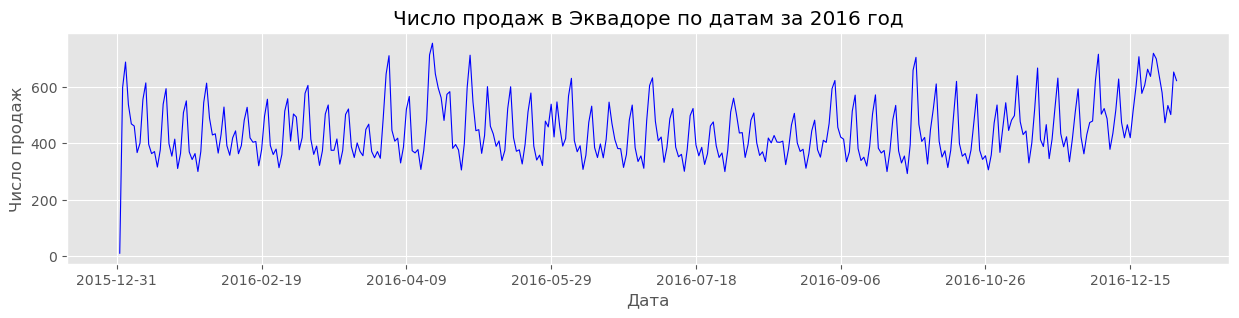

In [24]:
plotTimeSeries(data=trainDF, X="date", y="sales", xlabel="Дата", ylabel="Число продаж",
               title="Число продаж в Эквадоре по датам за 2016 год", color="blue",
               linewidth=0.8, savePath=f"{graphsDir}/Sales2016.png");

### Проверка стационарности ряда

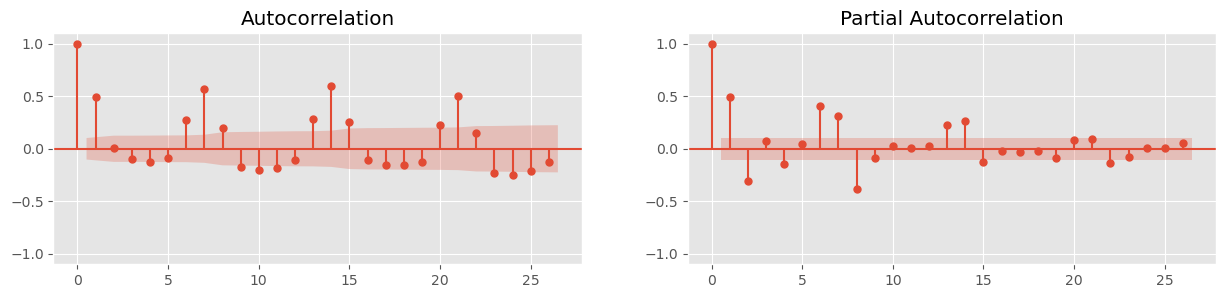

In [25]:
plotAcfPacf(data=trainDF, y="sales", savePath=f"{graphsDir}/AcfPacf.png")

In [26]:
adf_test = adfuller(trainDF["sales"])
print(f"p-value: {adf_test[1]}")

p-value: 0.6865947009636304


In [27]:
trainDF.head(5)

,date,lag1,lag2,lag3,dayofweek,quarter,month,dayofyear,day,week,sales,onpromotion,dcoilwtico,transactions
0,2016-01-01,23.0,8.000000,11.000,4,1,1,1,1,53,9.221882,0.089226,37.106277,1694.602158
1,2016-01-02,18.0,11.809999,28.361,5,1,1,2,2,53,598.584414,1.028058,36.970000,1854.274794
2,2016-01-03,31.0,35.353000,36.553,6,1,1,3,3,53,688.403883,1.647587,36.833723,1694.602158
3,2016-01-04,16.0,14.000000,18.444,0,1,1,4,4,1,536.451670,0.976992,36.810000,1585.427525
4,2016-01-05,11.0,14.000000,25.000,1,1,1,5,5,1,468.754455,2.216611,35.970000,1679.863003


### Приведение ряда к стационарному

In [28]:
trainDF_new = trainDF.set_index("date").diff().fillna(0).reset_index()

In [29]:
trainDF_new

,date,lag1,lag2,lag3,dayofweek,quarter,month,dayofyear,day,week,sales,onpromotion,dcoilwtico,transactions
0,2016-01-01,0.000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
1,2016-01-02,-5.000,3.809999,17.361000,1.0,0.0,0.0,1.0,1.0,0.0,589.362531,0.938833,-0.136277,159.672635
2,2016-01-03,13.000,23.543001,8.192000,1.0,0.0,0.0,1.0,1.0,0.0,89.819470,0.619529,-0.136277,-159.672635
3,2016-01-04,-15.000,-21.353000,-18.109000,-6.0,0.0,0.0,1.0,1.0,-52.0,-151.952214,-0.670595,-0.023723,-109.174634
4,2016-01-05,-5.000,0.000000,6.556000,1.0,0.0,0.0,1.0,1.0,0.0,-67.697214,1.239618,-0.840000,94.435478
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,2016-12-27,6.069,-1.000000,14.053000,1.0,0.0,0.0,1.0,1.0,0.0,-106.787463,0.745791,0.135065,-182.981481
361,2016-12-28,-1.160,-1.000000,-18.532000,1.0,0.0,0.0,1.0,1.0,0.0,61.199901,4.201459,1.190000,149.518519
362,2016-12-29,5.299,-9.000000,25.304300,1.0,0.0,0.0,1.0,1.0,0.0,-32.225296,-4.352974,-0.210000,-19.481481
363,2016-12-30,-20.340,23.000000,-17.304300,1.0,0.0,0.0,1.0,1.0,0.0,151.254097,3.421437,-0.050000,464.925926


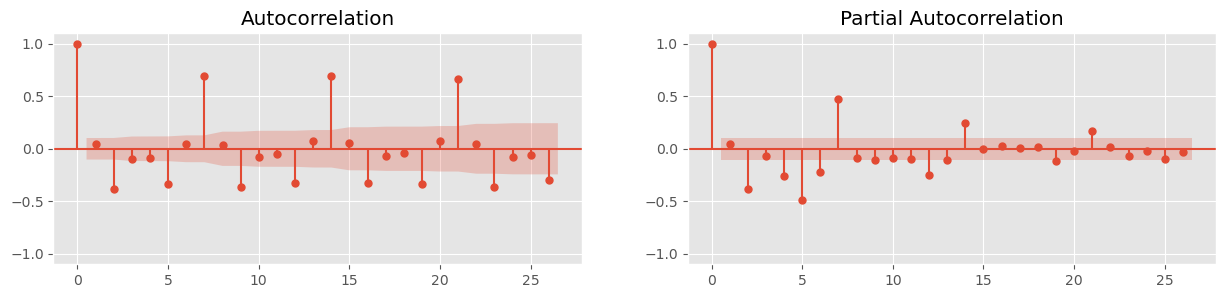

In [30]:
plotAcfPacf(data=trainDF_new, y="sales", savePath=f"{graphsDir}/AcfPacf.png")

In [31]:
adf_test = adfuller(trainDF_new["sales"])
print(f"p-value: {adf_test[1]}")

p-value: 6.328231406694943e-14


### Наивный прогноз

In [32]:
train_size = int(trainDF["sales"].size * 0.8)
test_size  = trainDF["sales"].size - train_size

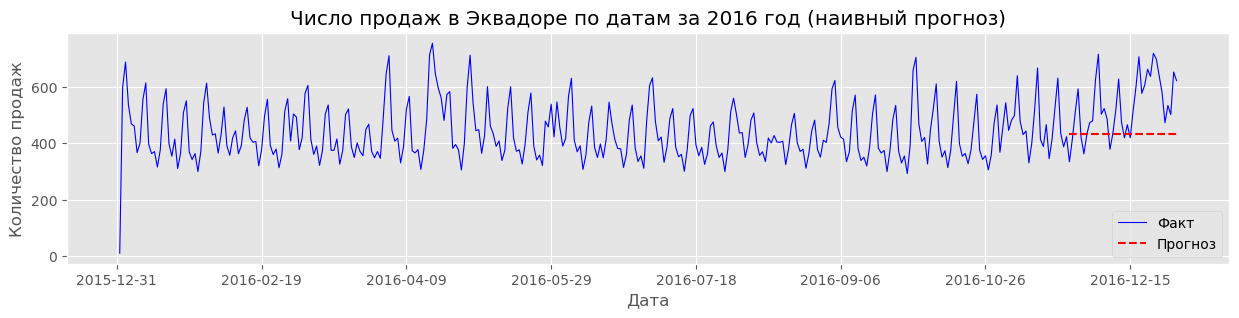

In [89]:
fig, ax = plt.subplots(1, 1, figsize=(15, 3))

trainDF["forecast_naive"] = [None]*train_size + [trainDF.loc[train_size - train_size*0.8:train_size, "sales"].mean()] * test_size
trainDF["prediction"] = [0] * train_size + [1] * test_size
trainDF_new["prediction"] = [0] * train_size + [1] * test_size

ax = plotTimeSeries(data=trainDF, X="date", y="sales", axs=ax, xlabel="Дата",
                    ylabel="Количество продаж", color="blue", label="Факт",
                    linewidth=0.8, title="Число продаж в Эквадоре по датам за 2016 год (наивный прогноз)")

ax = plotTimeSeries(data=trainDF, X="date", y="forecast_naive", axs=ax, xlabel="Дата",
                    ylabel="Количество продаж", color="red", label="Прогноз",
                    linestyle="--", title="Число продаж в Эквадоре по датам за 2016 год (наивный прогноз)",
                    savePath=f"{graphsDir}/SalesNaive.png")

### Прогноз ARIMA

In [90]:
model = ARIMA(trainDF_new.loc[:train_size, "sales"], order=(2, 1, 0))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                  329
Model:                 ARIMA(2, 1, 0)   Log Likelihood               -2019.270
Date:                Sat, 26 Oct 2024   AIC                           4044.540
Time:                        21:15:11   BIC                           4055.919
Sample:                             0   HQIC                          4049.079
                                - 329                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4006      0.052     -7.705      0.000      -0.503      -0.299
ar.L2         -0.5299      0.048    -11.066      0.000      -0.624      -0.436
sigma2        1.3e+04    828.450     15.690      0.0

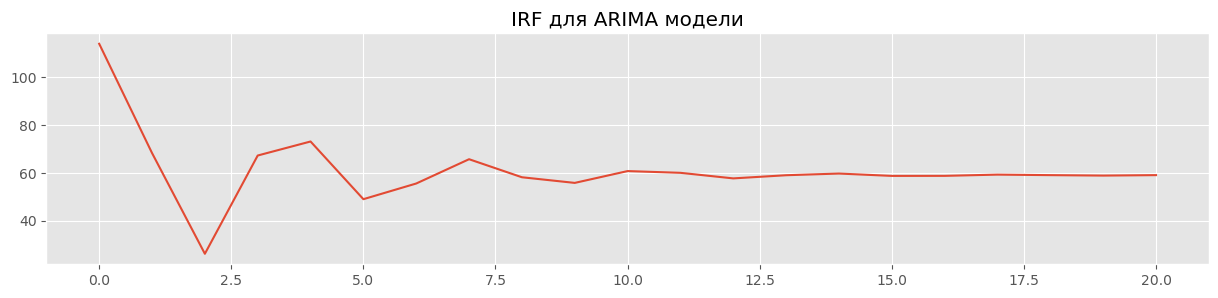

In [91]:
irf = model_fit.impulse_responses(20, orthogonalized=True, impulse=[1]).plot(figsize=(15,3), title="IRF для ARIMA модели")

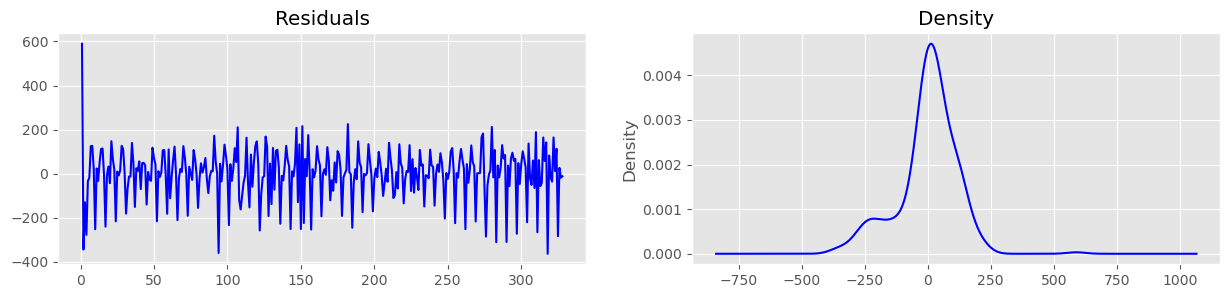

In [92]:
fig, ax = plt.subplots(1, 2, figsize=(15, 3))

residuals = model_fit.resid[1:]

residuals.plot(title="Residuals", ax=ax[0], color="blue")
residuals.plot(title="Density", kind="kde", ax=ax[1], color="blue")
plt.savefig(f"{graphsDir}/ResidualsDensity.png", bbox_inches='tight')

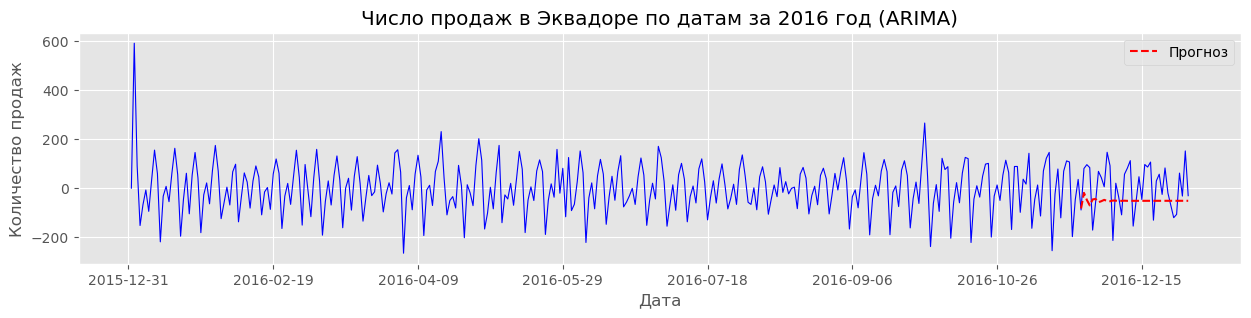

In [107]:
fig, ax = plt.subplots(1, 1, figsize=(15, 3))

forecast_test = model_fit.forecast(test_size)
trainDF_new["forecast_manual"] = [None]*train_size + list(forecast_test)

ax = plotTimeSeries(data=trainDF_new, X="date", y="sales", axs=ax, linewidth=0.8, color="blue")

ax = plotTimeSeries(data=trainDF_new, X="date", y="forecast_manual", axs=ax, xlabel="Дата",
                    ylabel="Количество продаж", color="red", 
                    title="Число продаж в Эквадоре по датам за 2016 год (ARIMA)", label="Прогноз",
                    linestyle="--", savePath=f"{graphsDir}/SalesARIMA.png")

In [ ]:
trainDF.head(5)

In [ ]:
train_size = int(trainDF.shape[0] * 0.9)
test_size  = trainDF.shape[0] - train_size

cols = ["onpromotion", "dcoilwtico", "transactions"]
X_train_timebased = trainDF.loc[:train_size, timeBasedFeatures]
X_test_timebased  = trainDF.loc[train_size:, timeBasedFeatures]

X_train_all = trainDF.loc[:train_size, timeBasedFeatures + cols]
X_test_all  = trainDF.loc[train_size:, timeBasedFeatures + cols]

y_train = trainDF.loc[:train_size, "sales"]
y_test  = trainDF.loc[train_size:, "sales"]

In [ ]:
model_timebased = SARIMAX(endog=y_train, exog=X_train_timebased).fit()
forecast_timebased = model_timebased.forecast(exog=X_test_timebased, steps=X_test_timebased.shape[0])

model_all = SARIMAX(endog=y_train, exog=X_train_all).fit()
forecast_all = model_all.forecast(exog=X_test_all, steps=X_test_all.shape[0])

In [94]:
trainDF["forecast_SARIMAX_timebased"] = [None]*train_size + list(forecast_timebased.values)
trainDF["forecast_SARIMAX_all"] = [None]*train_size + list(forecast_all.values)

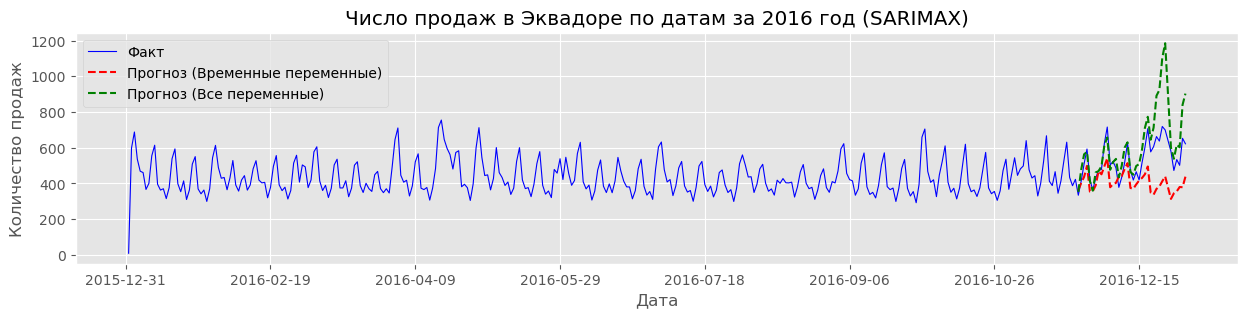

In [95]:
fig, ax = plt.subplots(1, 1, figsize=(15, 3))

ax = plotTimeSeries(data=trainDF, X="date", y="sales", axs=ax, xlabel="Дата",
                    ylabel="Количество продаж", color="blue", title="", label="Факт",
                    linewidth=0.8)

ax = plotTimeSeries(data=trainDF, X="date", y="forecast_SARIMAX_timebased", axs=ax, 
                    color="red", label="Прогноз (Временные переменные)", linestyle="--")

ax = plotTimeSeries(data=trainDF, X="date", y="forecast_SARIMAX_all", axs=ax, xlabel="Дата",
                    ylabel="Количество продаж", color="green", label="Прогноз (Все переменные)",
                    title="Число продаж в Эквадоре по датам за 2016 год (SARIMAX)",
                    linestyle="--", savePath=f"{graphsDir}/SalesSARIMAX.png")

### Прогнозирование ряда бустингом

In [96]:
def findBestParams(X_train: pd.DataFrame, y_train: pd.DataFrame):
    space = {
        'n_estimators':  scope.int(hp.quniform('n_estimators', 3000, 7000, 500)),
        'max_depth':     scope.int(hp.quniform('max_depth', 1, 10, 1)),
        'learning_rate': hp.loguniform('learning_rate', np.log(0.00001), np.log(1))
    }
    
    def objective(params):
        model = XGBRegressor(**params)
        split = TimeSeriesSplit(n_splits=10)
        score = cross_val_score(model, X_train, y_train, cv=split,
                                scoring='neg_mean_absolute_error').mean()
    
        return {'loss': -1*score, 'params': params, 'status': STATUS_OK}
    
    best_params = fmin(fn=objective, space=space, algo=tpe.suggest,
                       max_evals=60, trials=Trials(), verbose=1)
    
    return best_params

In [97]:
def getOptimalPrediction(X_train:pd.DataFrame, X_test:pd.DataFrame, y_train:pd.DataFrame, model):

    best_params = findBestParams(X_train=X_train_timebased, y_train=y_train)
    best_params.update({"max_depth": int(best_params["max_depth"]),
                        "n_estimators": int(best_params["n_estimators"])})

    model_inner = model(**best_params)
    model_inner.fit(X_train, y_train)
    prediction = model_inner.predict(X_test)

    return [best_params, prediction]

In [45]:
# ячейка выполняется долго. Лучше просто загрузить предрасчет
with open("Spec/specification.pkl", "rb") as f:
    spec = pickle.load(f)

if not UseBackUpData:
    coeffs, predictionTimebased = getOptimalPrediction(X_train=X_train_timebased, X_test=X_test_timebased, 
                                                       y_train=y_train, model=XGBRegressor)
    spec.update({"predictionTimebasedCoeffs": coeffs, "predictionTimebased": predictionTimebased})

    coeffs, predictionAll = getOptimalPrediction(X_train=X_train_all, X_test=X_test_all,
                                                 y_train=y_train, model=XGBRegressor)
    spec.update({"predictionAllCoeffs": coeffs, "predictionAll": predictionAll})
    
    with open("Spec/specification.pkl", "wb") as f:
        pickle.dump(spec, f)

100%|█████████| 60/60 [14:05<00:00, 14.09s/trial, best loss: 34.705256670455135]


In [98]:
with open("Spec/specification.pkl", "rb") as f:
    spec = pickle.load(f)

In [99]:
trainDF["pr_boosting_timebased"] = [None]*train_size + list(spec["predictionTimebased"])
trainDF["pr_boosting_all"] = [None]*train_size + list(spec["predictionAll"])

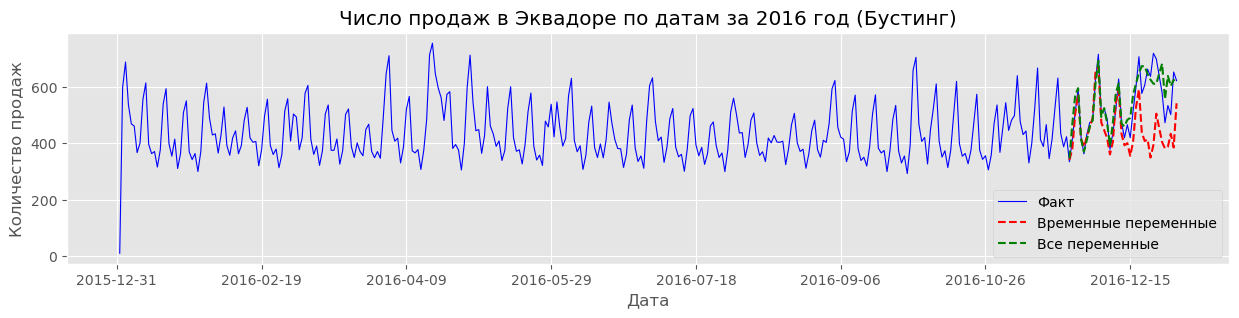

In [100]:
fig, ax = plt.subplots(1, 1, figsize=(15, 3))

ax = plotTimeSeries(data=trainDF, X="date", y="sales", axs=ax, color="blue", label="Факт", linewidth=0.8)

ax = plotTimeSeries(data=trainDF, X="date", y="pr_boosting_timebased", axs=ax, 
                    color="red", title="Число продаж в Эквадоре по датам за 2016 год (Бустинг)",
                    label="Временные переменные", linestyle="--")

ax = plotTimeSeries(data=trainDF, X="date", y="pr_boosting_all", axs=ax, xlabel="Дата",
                    ylabel="Количество продаж", color="green", title="Число продаж в Эквадоре по датам за 2016 год (Бустинг)",
                    label="Все переменные",
                    linestyle="--", savePath=f"{graphsDir}/SalesBoosting.png")

### Сравнение результатов

In [106]:
errorsDf = trainDF.query("prediction == 1")
errorsDf_stat = trainDF_new.query("prediction == 1")

stats = (
    errorsCheck(errorsDf["sales"], errorsDf["forecast_manual"])
    .rename(columns={"value":"manual"})
    .merge(errorsCheck(errorsDf["sales"], errorsDf["forecast_SARIMAX_timebased"])
           .rename(columns={"value":"SARIMAX (TimeBased)"}), on="metric")
    .merge(errorsCheck(errorsDf["sales"], errorsDf["forecast_SARIMAX_all"])
           .rename(columns={"value":"SARIMAX (TimeBased&Features)"}), on="metric")
    .merge(errorsCheck(errorsDf["sales"], errorsDf["forecast_naive"])
           .rename(columns={"value":"naive"}), on="metric")
    .merge(errorsCheck(errorsDf["sales"], errorsDf["pr_boosting_timebased"])
           .rename(columns={"value":"Bosting (TimeBased)"}), on="metric")
    .merge(errorsCheck(errorsDf["sales"], errorsDf["pr_boosting_all"])
           .rename(columns={"value":"Boosting (TimeBased&Features)"}), on="metric")
    .merge(errorsCheck(errorsDf_stat["sales"], errorsDf_stat["forecast_manual"])
       .rename(columns={"value":"ARIMA"}), on="metric")
)
stats

,metric,manual,SARIMAX (TimeBased),SARIMAX (TimeBased&Features),naive,Bosting (TimeBased),Boosting (TimeBased&Features),ARIMA
0,MSE,352023.352828,24258.073897,19785.570645,20703.855577,14971.714564,2745.548440,11908.607003
1,RMSE,593.315559,155.750037,140.661191,143.888344,122.358958,52.397981,109.126564
2,MAE,584.040116,125.469941,88.764964,114.747837,86.831467,39.191575,93.533725
3,Процентная ошибка,1.101000,0.216027,0.151230,0.195985,0.148649,0.073396,1.491618


### Заключение

В работе решалась задача прогнозирования числа продаж в сети магазинов Эквадора. Было рассмотрено 3 способа прогнозирования:
* ARIMA модель с ручной настройкой параметров p, d b q;
* SARIMAX модель;
* Модель машинного обучения (градиентный бустинг).

Для моделей бустинга и SARIMAX рассматривались прогнозы как только с временными переменными, там и с дополнительными, которые были представлены в исходном датасете.
Качество оценивалось с помощью следующих метрик: MSE, RMSE, MAE, абсолютная процентная ошибка. 
Результаты сравнивались с наивным прогнозом - срееднее число продаж за последнюю четверть тренировочного периода. Были получены следующие значения метрик:

| Метрика            | ARIMA         | SARIMAX      | XGBRegressor| Наивный прогноз |
|--------------------|---------------|--------------|-------------|-----------------|
| MSE                | 370425.063612 | 11849.563053 | 2761.131836 | 20720.685499    |
| RMSE               | 608.625553    | 108.855698   | 52.546473   | 143.946815      |
| MAE                | 600.125711    | 70.474641    | 42.322258   | 114.795845      |
| Процентная ошибка  | 1.133873      | 0.117918     | 0.080065    | 0.196057        |

По метрикам RMSE, MAE и процентной ошибке лучше всего себя показала ML модель. Второй по качеству оказалась SARIMAX модель. Полученные результаты можно объяснить тем, что ML модель имеет другую архитектуру (более сложный и тонкий процесс обучения), является более совершенной и новой, по сравнению с эконометрической моделью.
